# <img src="https://img.icons8.com/bubbles/100/000000/3d-glasses.png" style="height:50px;display:inline"> EE 046746 - Technion - Computer Vision

## Tutorial 10 - Structure From Motion
#### Elias Nehme
---
<img src="./assets/sfm_intro.jpg" width="800">

## <img src="https://img.icons8.com/bubbles/50/000000/checklist.png" style="height:50px;display:inline"> Agenda
---

* [SfM Intro](#-SfM-Intro)
    * [Pose Estimation](#-Pose-Estimation)
    * [Triangulation](#-Triangulation)
    * [Reconstruction](#-Reconstruction)
* [Multiview SfM](#-Multiview-SfM)
    * [Bundle-Adjustment](#-Bundle-Adjustment)
* [Exercise](#-Exercise---(Winter-2022-B,-Q1))
* [Recommended Videos](#-Recommended-Videos)
* [Credits](#-Credits)

### <img src="https://img.icons8.com/external-flatart-icons-outline-flatarticons/64/000000/external-3d-cube-3d-printing-flatart-icons-outline-flatarticons-1.png" style="height:50px;display:inline"> SfM Intro
--- 

<img src="./assets/sfm_process1.jpg" width="600">

### <img src="https://img.icons8.com/external-flatart-icons-outline-flatarticons/64/000000/external-3d-cube-3d-printing-flatart-icons-outline-flatarticons-1.png" style="height:50px;display:inline"> SfM Intro
--- 

<img src="./assets/sfm_process2.jpg" width="600">

### <img src="https://img.icons8.com/external-flatart-icons-outline-flatarticons/64/000000/external-3d-cube-3d-printing-flatart-icons-outline-flatarticons-1.png" style="height:50px;display:inline"> SfM Intro
--- 

<img src="./assets/sfm_process3.jpg" width="600">

### <img src="https://img.icons8.com/external-flatart-icons-outline-flatarticons/64/000000/external-3d-cube-3d-printing-flatart-icons-outline-flatarticons-1.png" style="height:50px;display:inline"> SfM Intro
--- 

<img src="./assets/sfm_process4.jpg" width="600">

### <img src="https://img.icons8.com/external-flatart-icons-outline-flatarticons/64/000000/external-3d-cube-3d-printing-flatart-icons-outline-flatarticons-1.png" style="height:50px;display:inline"> SfM Intro
--- 

<img src="./assets/sfm_process5.jpg" width="600">

### <img src="https://img.icons8.com/external-flatart-icons-outline-flatarticons/64/000000/external-3d-cube-3d-printing-flatart-icons-outline-flatarticons-1.png" style="height:50px;display:inline"> SfM Intro
--- 

* Reconstruction = Two-view Structure from Motion (SfM)
<img src="./assets/sfm_problems.jpg" width="600">

### <img src="https://img.icons8.com/external-kiranshastry-gradient-kiranshastry/64/000000/external-3d-virtual-reality-kiranshastry-gradient-kiranshastry.png" style="height:50px;display:inline"> Pose Estimation
--- 

* In pose estimation, our goal is to estimate the pose of the camera - given by the camera matrix $M$.
  * We assume we have a set of matched points $\{P_i, p_i\}$ - that match points in the real world, in their homogeneous coordinates, to points in the image, in their homogeneous coordinates.
  * This means for each pair $\{P_i, p_i\}$, the perspective camera model holds:
  $$p_i= MP$$
  * We've seen last tutorial that we can estimate M with SVD on $N_p$ points.
    * How many $N_p$ points?
  * We've seen we can rewrite $M$:
$$ M = K \left[R \lvert t\right] = K \left[R \lvert -Rc\right] = \left[N \lvert -Nc\right]$$ 
    * $c$ can be found via SVD of $M$ due to the relation: $ Mc = 0$
    * Then $N$ can be further decomposed into $N = K R $
    * This algorithm does not take into account noise, radial distortions, hard to impose prior knowledge (e.g. $f$), etc.
      * Solution? Minimize Reprojection errors = non-linear least squares
    

### <img src="https://img.icons8.com/external-kiranshastry-gradient-kiranshastry/64/000000/external-3d-virtual-reality-kiranshastry-gradient-kiranshastry.png" style="height:50px;display:inline"> Pose Estimation
--- 
* Assuming the camera intrinsics are calibrated ($K$ is known), how much DoF do we have?
* How much points $N_p$ do we need in this case?
* This problem is usually referred to as Perspective-n-Point (PnP).
* Can be solved in openCV using `cv2.solvePnP()`

In [1]:
import numpy as np
import cv2
import glob

# load the camera calibration results from tut 9: K (mtx) and distortion coeffs.
with np.load('./datasets/tut9_camera_calib.npz') as X:
    mtx, dist, _, _ = [X[i] for i in ('mtx','dist','rvecs','tvecs')]

In [2]:
# function that draws 3D axis at given image points starting from (0,0)
def draw(img, corners, imgpts):
    corner = tuple(corners[0].ravel())
    img = cv2.line(img, corner, tuple(imgpts[0].ravel()), (255,0,0), 5)
    img = cv2.line(img, corner, tuple(imgpts[1].ravel()), (0,255,0), 5)
    img = cv2.line(img, corner, tuple(imgpts[2].ravel()), (0,0,255), 5)
    return img

In [3]:
# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
# prepare object pts
objp = np.zeros((6*7,3), np.float32)
objp[:,:2] = np.mgrid[0:7,0:6].T.reshape(-1,2)
# define points of 3D axis (length=3 & origin at first detected corner)
axis = np.float32([[3,0,0], [0,3,0], [0,0,-3]]).reshape(-1,3)

In [4]:
# plot 3D axis on each image (X = Blue, Y = Green, Z = Red)
k = 0
for fname in glob.glob('./assets/left*.jpg'):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (7,6),None)
    if ret == True:
        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        # Find the rotation and translation vectors.
        ret, rvecs, tvecs = cv2.solvePnP(objp, corners2, mtx, dist)
        # project 3D points to image plane
        imgpts, jac = cv2.projectPoints(axis, rvecs, tvecs, mtx, dist)
        img = draw(img,corners2,imgpts)
        k += 1
        if k == 8:
            imexample = img
        cv2.imshow('img',img)
        cv2.waitKey(500)
cv2.destroyAllWindows()

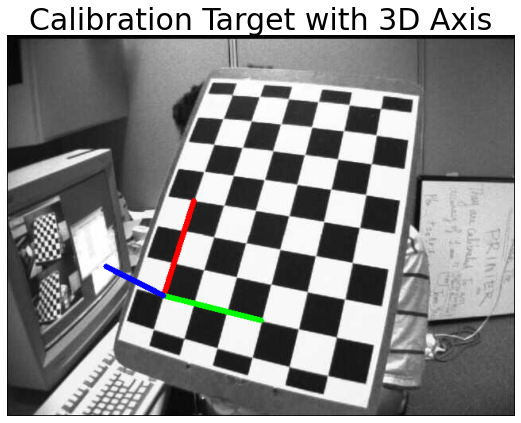

In [5]:
# show the last image and the projected axis
import matplotlib.pyplot as plt
plt.figure(figsize=(11,7))
plt.imshow(imexample)
plt.axis('off')
plt.title('Calibration Target with 3D Axis', fontsize=30)
plt.show()

In [6]:
# modified axis points to be corners of cube
axis = np.float32([[0,0,0], [0,3,0], [3,3,0], [3,0,0],
                   [0,0,-3],[0,3,-3],[3,3,-3],[3,0,-3] ])
# new drawing function
def draw(img, corners, imgpts):
    imgpts = np.int32(imgpts).reshape(-1,2)
    # draw ground floor in green
    img = cv2.drawContours(img, [imgpts[:4]],-1,(0,255,0),-3)
    # draw pillars in blue color
    for i,j in zip(range(4),range(4,8)):
        img = cv2.line(img, tuple(imgpts[i]), tuple(imgpts[j]),(255),3)
    # draw top layer in red color
    img = cv2.drawContours(img, [imgpts[4:]],-1,(0,0,255),3)
    return img

In [7]:
# plot 3D cube on each image (X = Blue, Y = Green, Z = Red)
k = 0
for fname in glob.glob('./assets/left*.jpg'):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (7,6),None)
    if ret == True:
        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        # Find the rotation and translation vectors.
        ret, rvecs, tvecs = cv2.solvePnP(objp, corners2, mtx, dist)
        # project 3D points to image plane
        imgpts, jac = cv2.projectPoints(axis, rvecs, tvecs, mtx, dist)
        img = draw(img,corners2,imgpts)
        k += 1
        if k == 8:
            imexample = img
        cv2.imshow('img',img)
        cv2.waitKey(500)
cv2.destroyAllWindows()

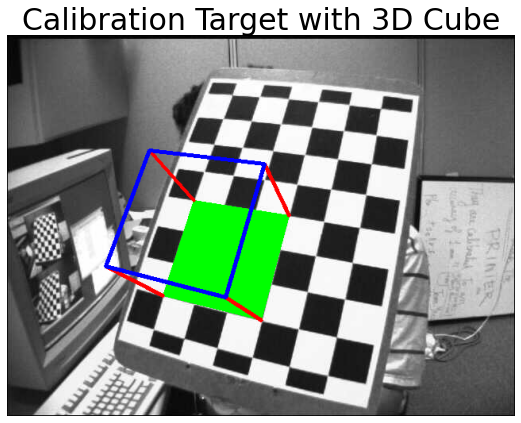

In [8]:
# show the last image and the projected cube
import matplotlib.pyplot as plt
plt.figure(figsize=(11,7))
plt.imshow(imexample)
plt.axis('off')
plt.title('Calibration Target with 3D Cube', fontsize=30)
plt.show()

### <img src="https://img.icons8.com/color/48/000000/3d-scale.png" style="height:50px;display:inline"> Triangulation
--- 

* In triangulation, our goal is to estimate the structure of the scene (the location of a point $P$ in the real world).
  * We assume we have a set of matched points $\{p_i, p'_i\}$ - that are matched homogeneous points in 2 different images.
  * We know the difference in geometry between the 2 cameras that took the images (their $K$, $R$ and $t$, or respectively $M$ and $M'$).
  * So we know that the point in the real world, $P$, lies on both of the rays from the camera's centers to the points $p,p'$:
  $$p=MP, p'=M'P$$
 
 <img src="./assets/sfm_tri5.jpg" style="height:300px">


### <img src="https://img.icons8.com/color/48/000000/3d-scale.png" style="height:50px;display:inline"> Triangulation
--- 

* We remember $p=\alpha MP$ as well, which gives us: 
$$p\times MP=0, p'\times M'P=0$$
* Switch to row-wise representation of the projection matrix:
$$ \begin{bmatrix} x \\ y  \\ 1 \end{bmatrix} = \begin{bmatrix} m_{11} & m_{12} & m_{13} & m_{14}\\ m_{21} & m_{22} & m_{23} & m_{24} \\ m_{31} & m_{32} & m_{33} & m_{34} \end{bmatrix}
\begin{bmatrix} X \\ Y  \\ Z \\ 1  \end{bmatrix} \leftrightarrow \begin{bmatrix} x \\ y  \\ 1 \end{bmatrix} = \begin{bmatrix} - & m_1^T & - \\ - & m_2^T & - \\ - & m_3^T & - \end{bmatrix} P$$

### <img src="https://img.icons8.com/color/48/000000/3d-scale.png" style="height:50px;display:inline"> Triangulation
--- 

* Leads to two independent equations:

$$ p \times M P = 0 \rightarrow \begin{bmatrix} y m_3^T P - m_2^T P \\ m_1^T P - x m_3^T P \end{bmatrix} = 0$$

* Using the matched point in image 2 as well $\rightarrow$ Solution by SVD:

$$ \begin{bmatrix} y m_3^T - m_2^T \\ m_1^T - x m_3^T \\ \tilde{y} \tilde{m}_3^T - \tilde{m}_2^T \\ \tilde{m}_1^T - \tilde{x} \tilde{m}_3^T \end{bmatrix} P = 0 \leftrightarrow A P = 0$$

### <img src="https://img.icons8.com/bubbles/50/000000/heart-puzzle.png" style="height:50px;display:inline"> How to Find Matching Points?
--- 



<img src="./assets/stereo_tri2.jpg" width="800">


### <img src="https://img.icons8.com/bubbles/50/000000/heart-puzzle.png" style="height:50px;display:inline"> How to Find Matching Points?
---

<img src="./assets/stereo_tri3.jpg" width="800">


### <img src="https://img.icons8.com/bubbles/50/000000/heart-puzzle.png" style="height:50px;display:inline"> How to Find Matching Points?
---

<img src="./assets/stereo_tri4.jpg" width="800">


### <img src="https://img.icons8.com/color/48/000000/3d-farm.png" style="height:50px;display:inline"> Reconstruction
--- 

* In Reconstruction, or **Structure from Motion**, our goal is to estimate both the structure of the scene, and the pose (motion) of the camera.
  * We assume we only have a set of matched points $\{p_i, p'_i\}$ - that are matched homogeneous points in 2 different images.
  * We want to estimate the geometry, by estimating both $M$ and $M'$, and we also want to estimate the 3D points $P_i$, the give us the structure of the scene.
 

### <img src="https://img.icons8.com/color/48/000000/3d-farm.png" style="height:50px;display:inline"> Reconstruction
--- 

The SfM pipeline is thus:
1. Get $\{p_i, p'_i\}$: Feature detection, feature description, and matching.
2. Estimate $F$ with the 8-point algorithm.
3. Estimate $M$ and $M'$:
  * If we know $K,K'$ we can estimate $E$ and from it get $M$.
  * Get $M,M'$ from $F$.
4. Once we have $\{p_i, p'_i\}, M, M'$ we can use triangulation to get $P_i$.
  * This SVD is usually called The Direct Linear Transformation (DLT).

### <img src="https://img.icons8.com/color/48/000000/3d-farm.png" style="height:50px;display:inline"> Reconstruction - Pose ambiguity
--- 

* Step 3 is ambiguous!
* Assuming calibrated camera intrinsics ($K$,$K'$ known) we have 4 options for $M$,$M'$.
  * We supposedly can get from $E$ both $R$ and $t$ (Using $E=[t_{\times}]R$ and $E=R[dC_{\times}]$), but since our ${p,p'}$ are defined up to a scale, we get 2 possible $R$ matrices, and 2 possible $t$ vectors:
* This happens because a projection matrix models also $z<0$, although not physically feasible.
* To decide between the different options we choose the one with 3D pts in front of the camera.

### <img src="https://img.icons8.com/color/48/000000/3d-farm.png" style="height:50px;display:inline"> Reconstruction - Scene ambiguity
--- 

<img src="./assets/sfm_ambiguity.jpg" width="600">

### <img src="https://img.icons8.com/color/48/000000/3d-farm.png" style="height:50px;display:inline"> SfM Pipeline Summary
--- 

<img src="./assets/sfm_2view3.jpg" width="600">

### <img src="https://img.icons8.com/ios/50/000000/unity.png" style="height:50px;display:inline"> Multiview SfM
--- 

<img src="./assets/sfm_mview1.jpg" width="600">

### <img src="https://img.icons8.com/ios/50/000000/unity.png" style="height:50px;display:inline"> Multiview SfM
--- 

<img src="./assets/sfm_mview2.jpg" width="600">

### <img src="https://img.icons8.com/ios/50/000000/unity.png" style="height:50px;display:inline"> Multiview SfM
--- 

<img src="./assets/sfm_mview3.jpg" width="600">

### <img src="https://img.icons8.com/external-tal-revivo-filled-tal-revivo/48/000000/external-layer-of-images-in-horizonal-grid-format-grid-filled-tal-revivo.png" style="height:40px;display:inline"> Bundle Adjustment
--- 

<img src="./assets/sfm_bundle1.jpg" width="600">

### <img src="https://img.icons8.com/external-tal-revivo-filled-tal-revivo/48/000000/external-layer-of-images-in-horizonal-grid-format-grid-filled-tal-revivo.png" style="height:40px;display:inline"> Bundle Adjustment
--- 

* We assume we have $m$ cameras observing a **stationary** 3D scene of $n$ points.
* Not all points (landmarks) are observed in each image. Can happen due to occlusions or noise (e.g. missed detections).
* The objective function is given by minimizing the re-projection error for all observed projections of the $n$ pts.
<img src="./assets/sfm_reprojerr.jpg" width="500">

### <img src="https://img.icons8.com/external-tal-revivo-filled-tal-revivo/48/000000/external-layer-of-images-in-horizonal-grid-format-grid-filled-tal-revivo.png" style="height:40px;display:inline"> Bundle Adjustment
--- 

* Minimization problem, assuming a calibrated moving camera with intrinsics $K$:

$$\hat{R}_i,\hat{t}_i,\hat{P}_j = \arg\min_{R_i,t_i,P_j} \sum_{i=1}^{m}\sum_{j=1}^{n} \alpha_{ij}\| p_{ij} - K\left[R_i\lvert t_i\right]P_j\|_2^2$$

where $\alpha_{ij}=1$ if point $j$ is present in camera $i$ and zero otherwise.


### <img src="https://img.icons8.com/external-tal-revivo-filled-tal-revivo/48/000000/external-layer-of-images-in-horizonal-grid-format-grid-filled-tal-revivo.png" style="height:40px;display:inline"> Bundle Adjustment
--- 
* The resulting problem is non-linear in $M_1,\dots,M_m$ and $P_1,\dots,P_n$.
* Solution obtained through some greedy optimization algorithm (e.g. Levenberg-Marquardt).
* Initialization matters in this case! 
    * Good initialization = Good local minima.

### <img src="https://img.icons8.com/external-tal-revivo-filled-tal-revivo/48/000000/external-layer-of-images-in-horizonal-grid-format-grid-filled-tal-revivo.png" style="height:40px;display:inline"> Bundle Adjustment
--- 
* The amount of unknowns is 11 per camera matrix $M_i$, and 3 per 3D point $P_j$.
* This is all true up to a projective transform $Q$ with 15 DoF.
* Since every 2D-2D correpondence gives 2 constraints, we end up with the condition:

$$2mn \geq 11m + 3n -15$$

### <img src="https://img.icons8.com/bubbles/50/000000/compose.png" style="height:50px;display:inline"> Exercise - (Winter 2022 B, Q1)
---

1. A camera is rotating around its axis in a fixed angular velocity, and taking photos of a palace from within. Is it possible to reconstruct the depth of the objects in the scene based on the taken pictures? Write down the mathematical relationship between the points in the image taken at time $t$ and the points in the image taken at $t+\Delta t$, when the camera has moved by an angle of $\theta$.
2. Now the camera is mounted on a drone and the drone is moving around the palace in a circular orbit (the drone's position is unknown). Is it possible to reconstruct the 3D shape of the palace?
3. $N$ camera matrices $M_1, ..., M_N\in \mathbb{R}^{3\times 4}$ are given. Write down the equations system for triangulating a 3D point $P$ by using 2D point-correspondences ($p_1, p_2, ..., p_N$) from $N$ different images, and describe how you can solve it.
4. Can you use the drone-mounted camera for reconstructing the 3D shape of a bird flapping her wings, at each point of time while it's flying? 


#### Solution
1. We can't recover the depth of the objects. When the two views are separated by a pure rotation, the mapping of the points in the images are given by a homography. 
$$H = KR_{\theta}^{-1}K^{-1}$$

2. Now the camera is mounted on a drone and the drone is moving around the palace in a circular orbit (the drone's position is unknown). Is it possible to reconstruct the 3D shape of the palace?


#### Solution
2. Now we *can* recover the depth objects in the scene (specifically - the shape of the palace). This is the classic SfM setup we've just learned, where we can infer both the camera matrices and the 3D shape of the objects based on keypoint matching. 

3. $N$ camera matrices $M_1, ..., M_N\in \mathbb{R}^{3\times 4}$ are given. Write down the equations system for triangulating a 3D point $P$ by using $N$ 2D point-correspondences ($p_1, p_2, ..., p_N$) from $N$ different images, and describe how you can solve it.

#### Solution
3. As denoted before, $p_i = (x_i, y_i)^T$, and $M_i = \left[ \begin{matrix} - & m_{i,1}^T & - \\ - & m_{i,2}^T & - \\ - & m_{i,3}^T & -\end{matrix}\right]$.  
We can now write the triangulation equation with $N$ cameras for a single point $P$ by extending the equation from the lecture and this tutorial for more matches:
$$\left[ \begin{matrix} y_1 m_{1,3}^T - m_{1,2}^T \\ m_{1,1}^T - x_1 m_{1,3}^T \\ \vdots \\ y_N m_{N,3}^T - m_{N,2}^T \\ m_{N,1}^T - x_N m_{N,3}^T  \end{matrix}\right] P = AP = 0$$
The solution is given by SVD (homogeneous linear system).


4. Can you use the drone-mounted camera for reconstructing the 3D shape of a bird flapping her wings, at each point of time while it's flying? 


#### Solution
4. Since we don't have a rigid body assumption on the bird's motion, we will not be able to reconstruct the shape of the bird using the proposed method. Our basic assumption in SfM is that the scene is static, and when the bird is flapping her wings the motion of the points will not be described by a simple matrix.

### <img src="https://img.icons8.com/bubbles/50/000000/video-playlist.png" style="height:50px;display:inline"> Recommended Videos
---
#### <img src="https://img.icons8.com/cute-clipart/64/000000/warning-shield.png" style="height:30px;display:inline"> Warning!
* These videos do not replace the lectures and tutorials.
* Please use these to get a better understanding of the material, and not as an alternative to the written material.

#### Video By Subject
* Computer Vision First Principles - <a href="https://www.youtube.com/watch?v=JlOzyyhk1v0&ab_channel=FirstPrinciplesofComputerVision">Shree Nayar</a>
* Structure from Motion Pipeline - <a href="https://www.youtube.com/watch?v=i7ierVkXYa8&ab_channel=DrCalleOlsson">Calle Olsson</a>

## <img src="https://img.icons8.com/dusk/64/000000/prize.png" style="height:50px;display:inline"> Credits
----
* EE 046746 Spring 2022 - <a href="https://github.com/HilaManor">Hila Manor</a>
* EE 046746 Winter 2021 - <a href="https://eliasnehme.github.io/">Elias Nehme</a>
* <a href="https://cmsc426.github.io/gtsam/">GTSAM blog in Computer Vision Class (U. Maryland) </a> - <a href="https://nitinjsanket.github.io/">Nitin J. Sanket</a>
* Slides (Princeton) - <a href="http://3dvision.princeton.edu/courses/SFMedu/slides.pdf">Jianxiong Xiao</a>
* Slides (CS Technion) - <a href="https://scholar.google.com/citations?user=_STeqhAAAAAJ&hl=en">Elad Osherov</a>
* Slides (CMU) - <a href="https://www.cs.cmu.edu/~igkioule/">Ioannis Gkioulekas</a>, <a href="http://www.cs.cmu.edu/~kkitani/">Kris Kitani</a>, <a href="http://www.cs.cmu.edu/~srinivas/">Srinivasa Narasimhan</a> 
* Multiple View Geometry in Computer Vision - Hartley and Zisserman - Chapter 9, 18
* <a href="https://www.springer.com/gp/book/9781848829343">Computer Vision: Algorithms and Applications</a> - Richard Szeliski - Chapter 7

* Icons from <a href="https://icons8.com/">Icon8.com</a> - https://icons8.com
